# imports

In [3]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from rasterio.plot import show

# Data load

In [4]:
# Directories
non_forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\non_forest"
forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\forest"

# Load all TIFF files from a directory
def load_tif_files(directory):
    tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]
    return tif_files, [rasterio.open(f).read() for f in tif_files]

non_forest_files, non_forest_data = load_tif_files(non_forest_dir)
forest_files, forest_data = load_tif_files(forest_dir)

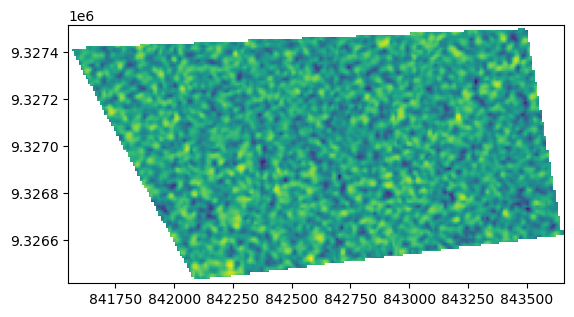

Non-Forest Image Resolution: 10.0 x 10.0 meters per pixel


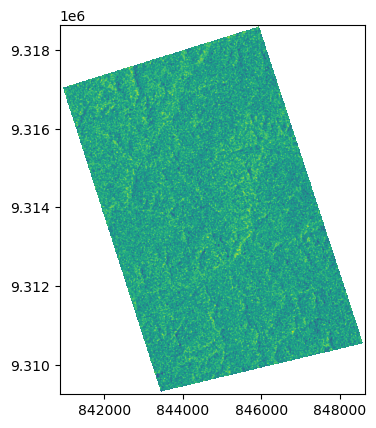

Forest Image Resolution: 10.0 x 10.0 meters per pixel


In [5]:
# Calculate and display image resolution
def display_example_image(file_path, title):
    with rasterio.open(file_path) as img:
        show(img)
        res_x, res_y = img.transform[0], abs(img.transform[4])
        print(f"{title} Image Resolution: {res_x} x {res_y} meters per pixel")

display_example_image(non_forest_files[0], "Non-Forest")
display_example_image(forest_files[0], "Forest")

## Few tile optinal features

Training set: 380452 samples, Validation set: 81525 samples, Test set: 81526 samples


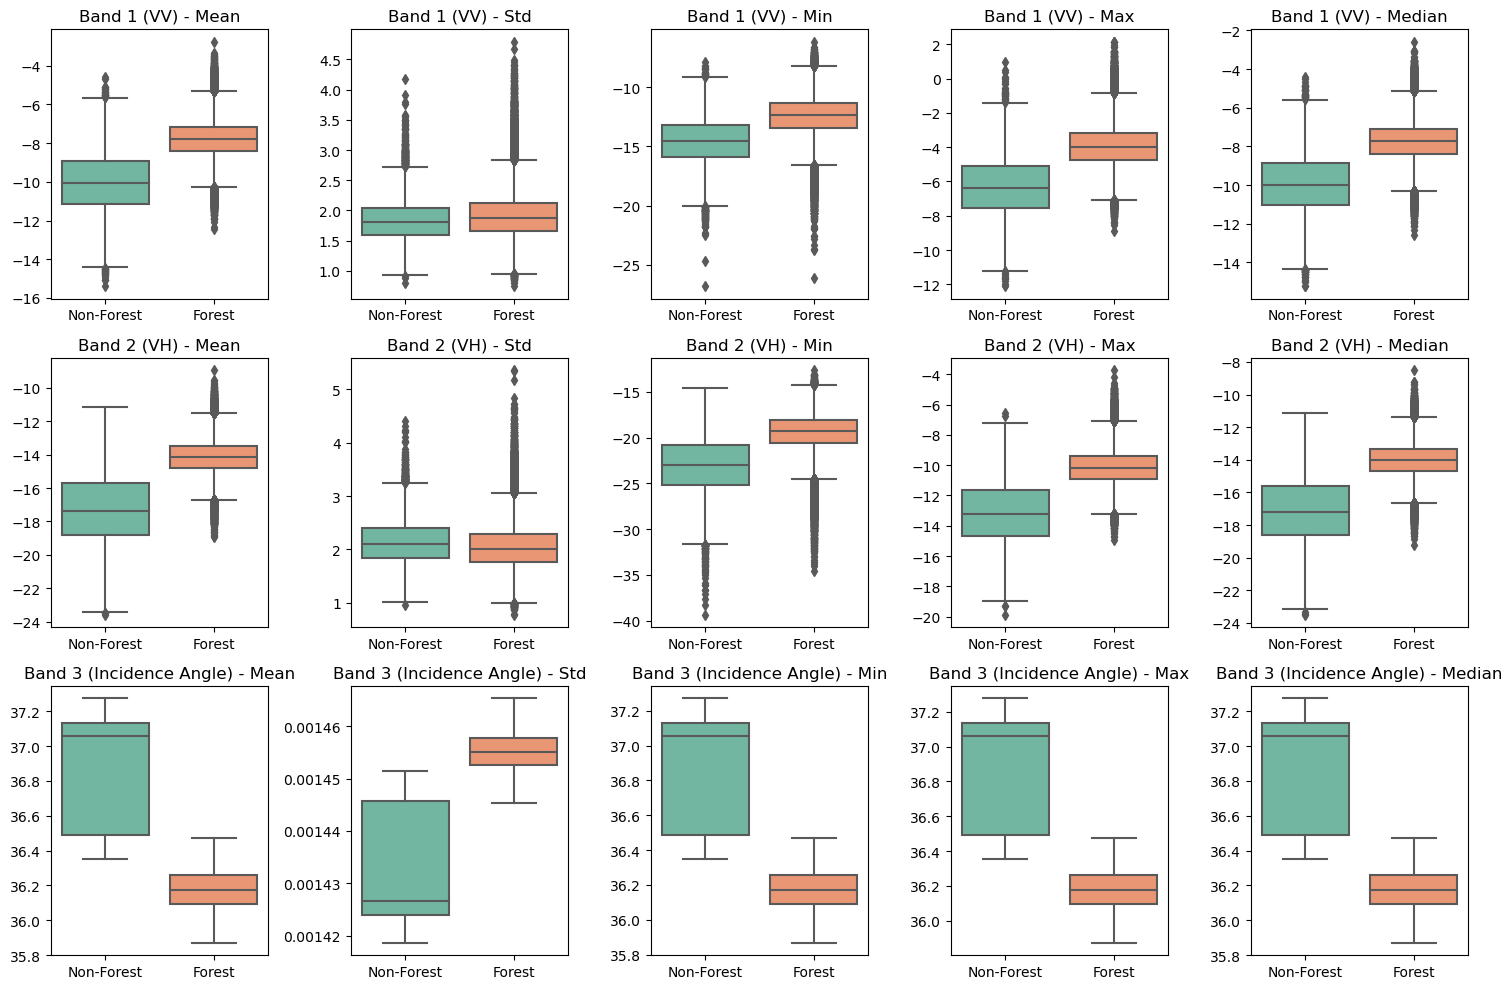

In [7]:
def extract_tile_features(tile):
    return [stat for band in tile for stat in (band.mean(), band.std(), band.min(), band.max(), np.median(band))]

# Divide image into tiles and compute features
def tile_image(image, tile_size=16):
    h, w = image.shape[1], image.shape[2]
    return np.array([extract_tile_features(image[:, i:i+tile_size, j:j+tile_size])
                     for i in range(0, h, tile_size) for j in range(0, w, tile_size)
                     if image[:, i:i+tile_size, j:j+tile_size].shape[1:] == (tile_size, tile_size)])

# Apply tiling and feature extraction
selected_tile_size = 8
non_forest_tiles = np.vstack([tile_image(b, selected_tile_size) for b in non_forest_data])
forest_tiles = np.vstack([tile_image(b, selected_tile_size) for b in forest_data])

# Combine and label tiles
X = np.vstack([non_forest_tiles, forest_tiles])
y = np.hstack([np.zeros(len(non_forest_tiles)), np.ones(len(forest_tiles))])

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape[0]} samples, Validation set: {X_val.shape[0]} samples, Test set: {X_test.shape[0]} samples")

# Visualize statistical features
def visualize_features(X, y, title=""):
    bands = ['Band 1 (VV)', 'Band 2 (VH)', 'Band 3 (Incidence Angle)']
    features = ['Mean', 'Std', 'Min', 'Max', 'Median']
    plt.figure(figsize=(15, 10))
    for i, band in enumerate(bands):
        for j, feat in enumerate(features):
            plt.subplot(len(bands), len(features), i * len(features) + j + 1)
            sns.boxplot(data=[X[y==0, i*5+j], X[y==1, i*5+j]], palette="Set2")
            plt.title(f'{band} - {feat}')
            plt.xticks([0, 1], ['Non-Forest', 'Forest'])
    plt.tight_layout()
    plt.show()

visualize_features(X_train, y_train, "Training Set")

In [9]:
# Gather and shuffle band values
def gather_band_values(data, band_idx, num_samples=1000):
    values = [tile[band_idx].flatten() for tile in data]
    flat_values = np.hstack(values)
    random.shuffle(flat_values)
    return flat_values[:num_samples]

## Look into the data

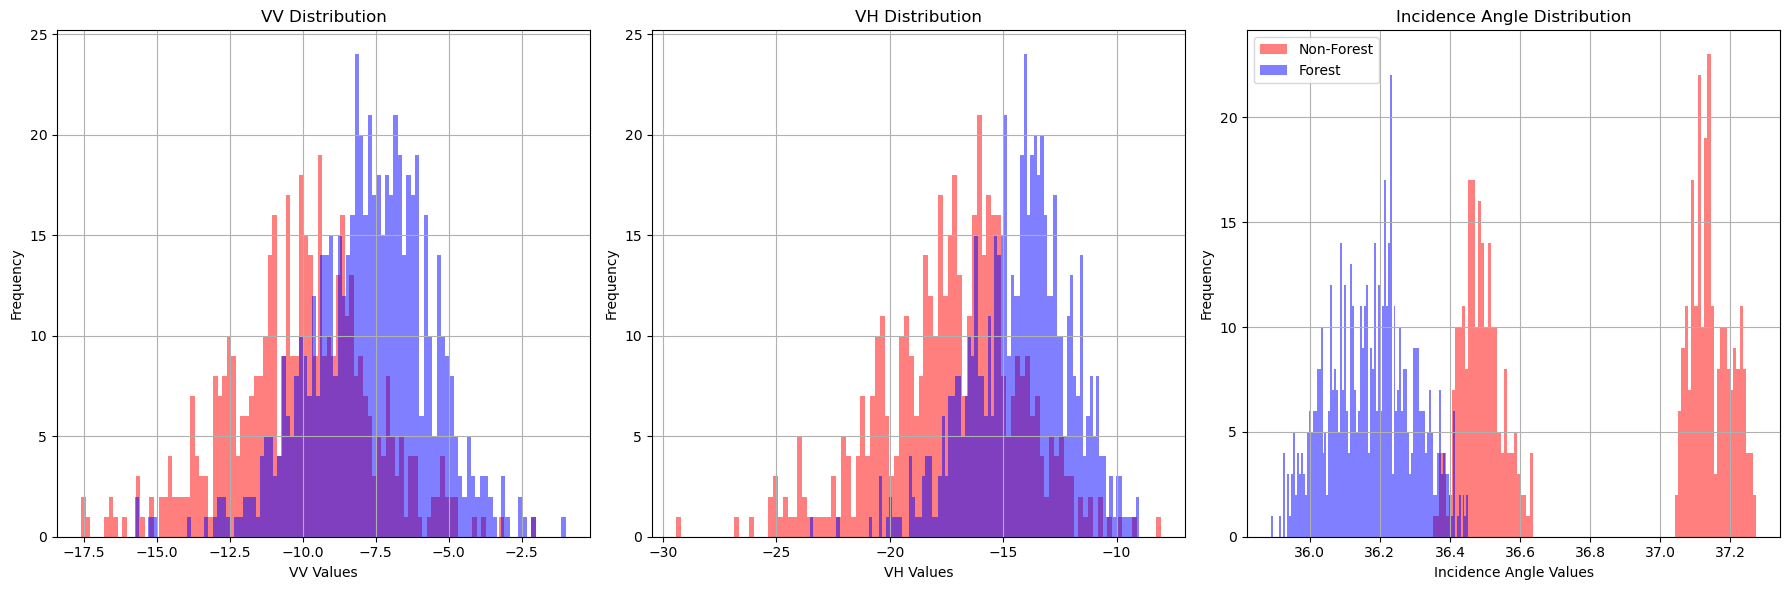

In [10]:
# Plot band distributions
def plot_band_distribution(non_forest, forest):
    plt.figure(figsize=(18, 6))
    for i, band in enumerate(['VV', 'VH', 'Incidence Angle']):
        plt.subplot(1, 3, i + 1)
        plt.hist(gather_band_values(non_forest, i), bins=100, color='red', alpha=0.5, label='Non-Forest')
        plt.hist(gather_band_values(forest, i), bins=100, color='blue', alpha=0.5, label='Forest')
        plt.title(f'{band} Distribution')
        plt.xlabel(f'{band} Values')
        plt.ylabel('Frequency')
        plt.grid(True)
        if i == 2:
            plt.legend()
    plt.tight_layout()
    plt.show()

plot_band_distribution(non_forest_data, forest_data)

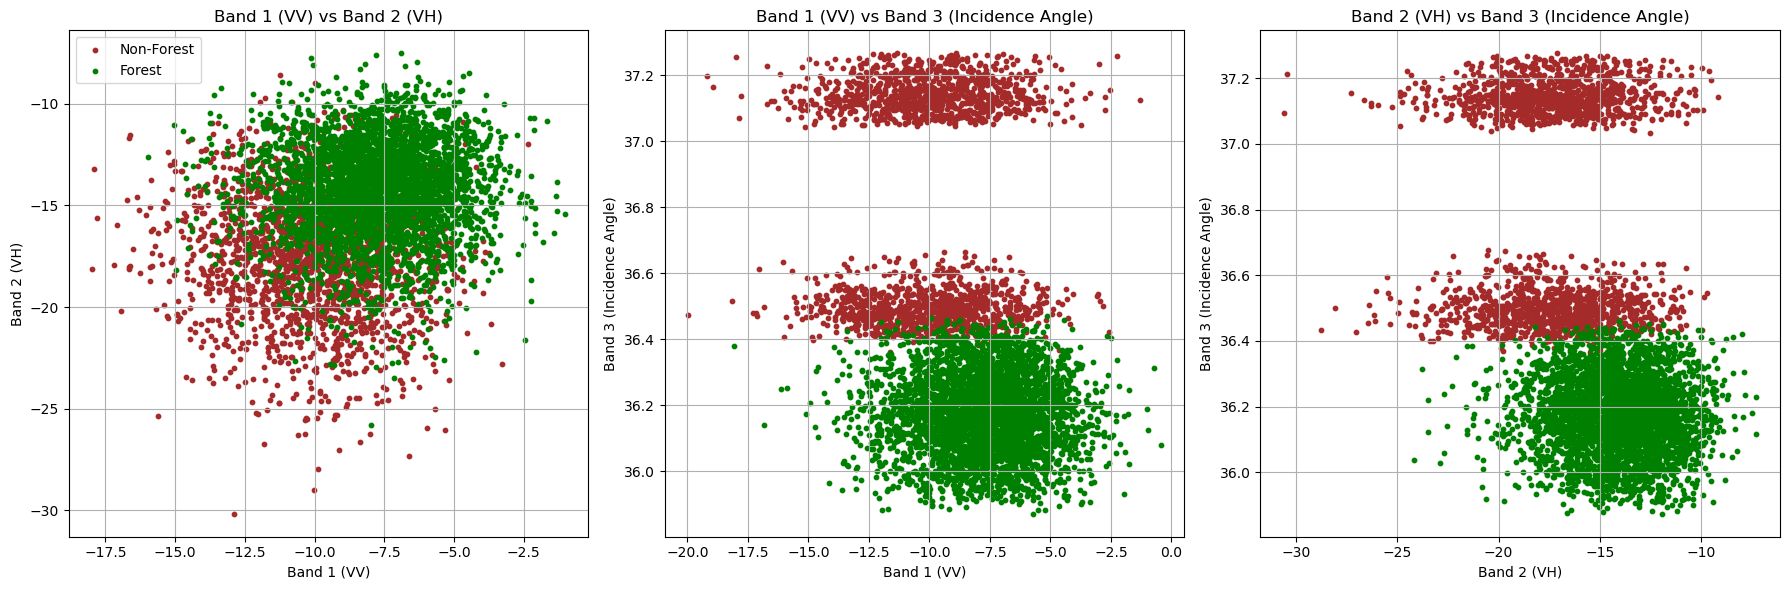

In [12]:
# Scatter plot for band combinations
def plot_band_combinations(non_forest, forest, num_samples=1000):
    band_pairs = [(0, 1), (0, 2), (1, 2)]
    band_names = ['Band 1 (VV)', 'Band 2 (VH)', 'Band 3 (Incidence Angle)']
    plt.figure(figsize=(18, 6))
    for i, (x, y) in enumerate(band_pairs):
        plt.subplot(1, 3, i + 1)
        plt.scatter(gather_band_values(non_forest, x, num_samples), gather_band_values(non_forest, y, num_samples), 
                    color='brown', s=10, label='Non-Forest')
        plt.scatter(gather_band_values(forest, x, num_samples), gather_band_values(forest, y, num_samples), 
                    color='green', s=10, label='Forest')
        plt.title(f"{band_names[x]} vs {band_names[y]}")
        plt.xlabel(band_names[x])
        plt.ylabel(band_names[y])
        plt.grid(True)
        if i == 0:
            plt.legend()
    plt.tight_layout()
    plt.show()

plot_band_combinations(non_forest_data, forest_data, num_samples=10000)

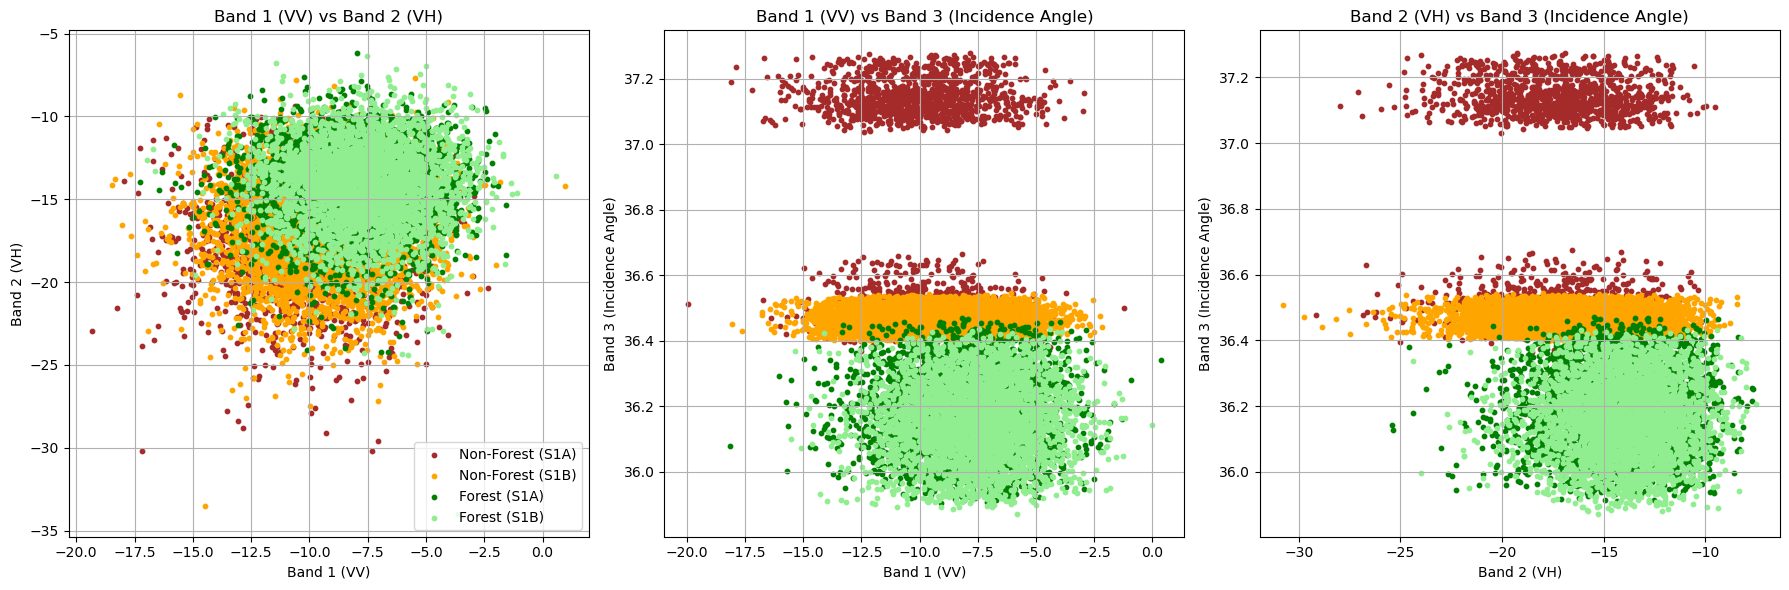

In [16]:
# Filter data by prefix and plot band combinations
def filter_and_plot_by_sat_name(directory, prefix):
    files, data = load_tif_files(directory)
    filtered_data = [d for f, d in zip(files, data) if os.path.basename(f).startswith(prefix)]
    return filtered_data

def plot_band_combinations_by_groups(non_forest_dir, forest_dir, num_samples=1000):
    non_forest_s1a = filter_and_plot_by_sat_name(non_forest_dir, 'S1A')
    non_forest_s1b = filter_and_plot_by_sat_name(non_forest_dir, 'S1B')
    forest_s1a = filter_and_plot_by_sat_name(forest_dir, 'S1A')
    forest_s1b = filter_and_plot_by_sat_name(forest_dir, 'S1B')
    band_pairs = [(0, 1), (0, 2), (1, 2)]
    band_names = ['Band 1 (VV)', 'Band 2 (VH)', 'Band 3 (Incidence Angle)']
    plt.figure(figsize=(18, 6))
    for i, (x, y) in enumerate(band_pairs):
        plt.subplot(1, 3, i + 1)
        plt.scatter(gather_band_values(non_forest_s1a, x, num_samples), gather_band_values(non_forest_s1a, y, num_samples), 
                    color='brown', s=10, label='Non-Forest (S1A)')
        plt.scatter(gather_band_values(non_forest_s1b, x, num_samples), gather_band_values(non_forest_s1b, y, num_samples), 
                    color='orange', s=10, label='Non-Forest (S1B)')
        plt.scatter(gather_band_values(forest_s1a, x, num_samples), gather_band_values(forest_s1a, y, num_samples), 
                    color='green', s=10, label='Forest (S1A)')
        plt.scatter(gather_band_values(forest_s1b, x, num_samples), gather_band_values(forest_s1b, y, num_samples), 
                    color='lightgreen', s=10, label='Forest (S1B)')
        plt.title(f"{band_names[x]} vs {band_names[y]}")
        plt.xlabel(band_names[x])
        plt.ylabel(band_names[y])
        plt.grid(True)
        if i == 0:
            plt.legend()
    plt.tight_layout()
    plt.show()

plot_band_combinations_by_groups(non_forest_dir, forest_dir, num_samples=10000)